In [12]:
import numpy as np
import numpy.linalg
import scipy as sp
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [308]:
def covariance(x1, x2):
    if np.shape(x1) == ():
        x1 = np.array([x1])
    if x1.ndim == 1:
        x1 = np.expand_dims(x1, 1)
    if np.shape(x2) == ():
        x2 = np.array([x2])
    if x2.ndim == 1:
        x2 = np.expand_dims(x2, 1)
    sq_norm = -0.5*sp.spatial.distance.cdist(x1, x2, 'sqeuclidean')
    return np.exp(sq_norm)

In [200]:
covariance(X1,1)

array([[1.        ],
       [0.60653066],
       [0.13533528],
       [0.011109  ]])

In [70]:
num_samples = 41
num_functions = 5
X = np.expand_dims(np.linspace(-4, 4, num_samples), 1)
Sigma = covariance(X, X)
ys = np.random.multivariate_normal(mean = np.zeros(num_samples), cov=Sigma, size=num_functions)
confidence = np.array([covariance([x], [x]) for x in X])
confidence = np.concatenate(confidence, axis=0)

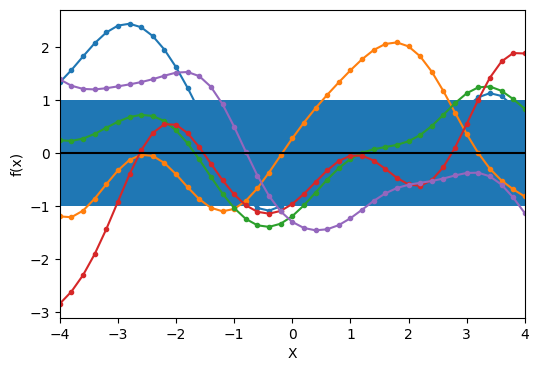

In [56]:
plt.figure(figsize=(6,4))
for i in range(num_functions):
    plt.plot(X, ys[i], linestyle='-', marker='o', markersize=3)
plt.plot(X, np.zeros(num_samples), color='0')
plt.fill_between(np.rot90(X)[0], np.rot90(confidence)[0], np.rot90(-confidence)[0])
plt.xlabel('X')
plt.ylabel('f(x)')
plt.xlim([-4,4])
plt.show()

In [138]:
def prior_mean(X):
    if np.shape(x) == ():
        return 0
    return np.zeros(len(X))

In [237]:
def cross_covariance(X1, x):
    if np.shape(x) == ():
        return covariance(X1, np.array([x]))
    return covariance(X1, x)
def posterior_mean(X1, Y1, x, prior_mean, Precision):
    return prior_mean(x) + np.linalg.matmul(np.rot90(cross_covariance(X1, x)), np.linalg.matmul(Precision, Y1-prior_mean(X1)))
def posterior_covariance(X1, Y1, x1, x2, covariance, Precision):
    return covariance(x1, x2) - np.linalg.matmul(np.rot90(covariance(X1, x1)), np.linalg.matmul(Precision, covariance(X1, x2)))
def gram_matrix(covariance, X, X1, Y1, Precision):
    length = len(X)
    matrix = np.zeros((length, length))
    for i in range(length):
        for j in range(i, length):
            res = posterior_covariance(X1, Y1, X[i], X[j], covariance, Precision)[0][0]
            matrix[i][j] = res
            matrix[j][i] = res
    return matrix

In [254]:
X1 = np.array([1,2,4])
Y1 = np.array([1,2,4])
X2 = np.array([1.5, 2.5, 3.5, 6])
Sigma = covariance(X1, X1)
Precision = np.linalg.inv(Sigma)
#posterior_mean(X1, Y1, 1.5, prior_mean, Precision)
#posterior_covariance(X1, Y1, X, X, covariance, Precision)
#posterior_covariance(X1, Y1, 0, 0, covariance, Precision)

In [299]:
def GP_posterior(X1, Y1, kernel, X2, noise=None):
    if (noise != None) and (np.shape(noise) == ()):
        noise = noise * np.identity(len(X1))
    Sigma = kernel(X1, X1)
    Precision = np.linalg.inv(Sigma)
    mean_vals = posterior_mean(X1, Y1, X2, prior_mean, Precision)[::-1]
    matrix = gram_matrix(kernel, X2, X1, Y1, Precision)
    post_variance = np.diagonal(matrix)
    lower_conf = mean_vals - post_variance
    upper_conf = mean_vals + post_variance
    return mean_vals, lower_conf, upper_conf, matrix

In [277]:
mean_vals, lower_conf, upper_conf, matrix = GP_posterior(X1, Y1, covariance, X)

In [279]:
def sample(X, mean_vals, matrix, num_samples):
    return X, np.random.multivariate_normal(mean=mean_vals, cov=matrix, size=num_samples)

In [306]:
def plot(num_functions, ys, upper_conf, lower_conf, mean_vals, X_plot, X_train, Y_train):
    plt.figure(figsize=(6,4))
    for i in range(num_functions):
        plt.plot(X_plot, ys[i], linestyle='-')
    plt.plot(X_plot, mean_vals, color='0')
    plt.plot(X_train, Y_train, 'o', color='r')
    plt.fill_between(np.rot90(X_plot)[0], lower_conf, upper_conf, color='grey')
    plt.xlabel('X')
    plt.ylabel('f(x)')
    plt.xlim([-6,6])
    plt.show()

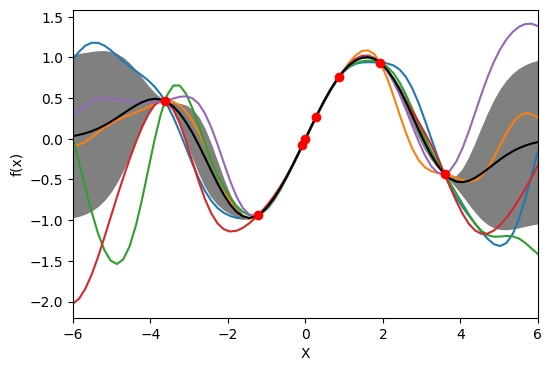

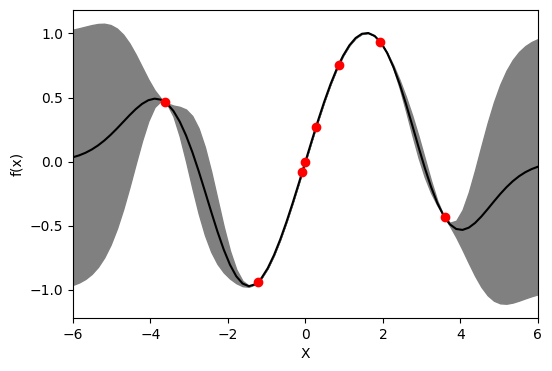

In [310]:
X_plot, Ys = sample(X_plot, mean_vals2, matrix2, 5)
plot(5, Ys, upper_conf2, lower_conf2, mean_vals2, X_plot, X3, Y3)
plot(0, [], upper_conf2, lower_conf2, mean_vals2, X_plot, X3, Y3)

In [309]:
f_sin = lambda x: (np.sin(x)).flatten()

n1 = 8  # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
domain = (-6, 6)

# Sample observations (X1, y1) on the function
X3 = np.random.uniform(domain[0]+2, domain[1]-2, size=n1)
Y3 = f_sin(X3)
# Predict points at uniform spacing to capture function
X_plot = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)
# Compute posterior mean and covariance
mean_vals2, lower_conf2, upper_conf2, matrix2 = GP_posterior(X3, Y3, covariance, X_plot)